# End-to-end example: Compare models, direct prediction

In [1]:
import ccxt
import pandas as pd
import numpy as np
import requests
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt
# import libs helpers
from helpers.ocean_helpers import calc_nmse 

In [2]:

cex_x = ccxt.binance().fetch_ohlcv('ETH/USDT', '1h')

# create a Data Frame with two columns [date,eth-prices] with dates given in intervals of 1-hour
import pandas as pd
data = pd.DataFrame(cex_x, columns=['date', 'open', 'max', 'min', 'close', 'volume'])
data['date'] = pd.to_datetime(data['date'],unit='ms')

# Divide the data in training and testing set. Because the data has temporal structure, we split the data in two blocks, vs. selecting randomly.
# 90% of the data is used for training and 10 is used for testing
train_rate = 0.9
n = data.shape[0]
ntrain = int(np.floor(n*train_rate))
train_data = data.iloc[0:ntrain,:]
test_data = data.iloc[ntrain:,:]

# Create feature vectors
# - Define how many samples in the past are used to predict future values. 
# - This also defines the number of smaples to be predicted in the future.
max_lag = 12 

# Create feature vectors with 12 columns, each representing a time-lag from the current time point
# - That is: x(t-1), x(t-2)...x(t-12) for close and open values (different features could be grouped using the same logic)
full_train_close = pd.concat([train_data['close'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
full_train_open = pd.concat([train_data['open'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
# targets are multivariate, with the values of eth from 1 - 12 hours ahead of the curent time
y_train = full_train_close[max_lag:,:]
# train set is lagged with respect to the targets
x_train = np.concatenate((full_train_close[0:-max_lag,:],full_train_open[0:-max_lag,:]),axis=1)

# Repeat the feature vector creation as above for the test set
full_test_close = pd.concat([test_data['close'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
full_test_open = pd.concat([test_data['open'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
y_test = full_test_close[max_lag:,:]
x_test = np.concatenate((full_test_close[0:-max_lag,:],full_test_open[0:-max_lag,:]),axis=1)

In [6]:
n

500

In [3]:
data

,date,open,max,min,close,volume
0,2023-01-18 22:00:00,1528.46,1531.67,1517.39,1531.38,12766.0369
1,2023-01-18 23:00:00,1531.39,1533.28,1507.90,1511.43,21837.7252
2,2023-01-19 00:00:00,1511.44,1523.25,1509.15,1516.26,18982.5522
3,2023-01-19 01:00:00,1516.25,1523.80,1515.51,1518.14,9312.9368
4,2023-01-19 02:00:00,1518.15,1526.38,1513.91,1525.07,9716.0774
...,...,...,...,...,...,...
495,2023-02-08 13:00:00,1671.90,1676.44,1668.30,1674.64,18216.3982
496,2023-02-08 14:00:00,1674.64,1681.98,1661.68,1671.28,31971.2240
497,2023-02-08 15:00:00,1671.28,1671.29,1649.51,1653.08,40209.5068
498,2023-02-08 16:00:00,1653.08,1654.85,1630.47,1653.47,55209.7895


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-08 11:19:11.654678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 11:19:11.655315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-08 11:19:11.920700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-08 11:19:12.211775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 11:19:12.964424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 45ms/step


2023-02-08 11:19:29.419637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


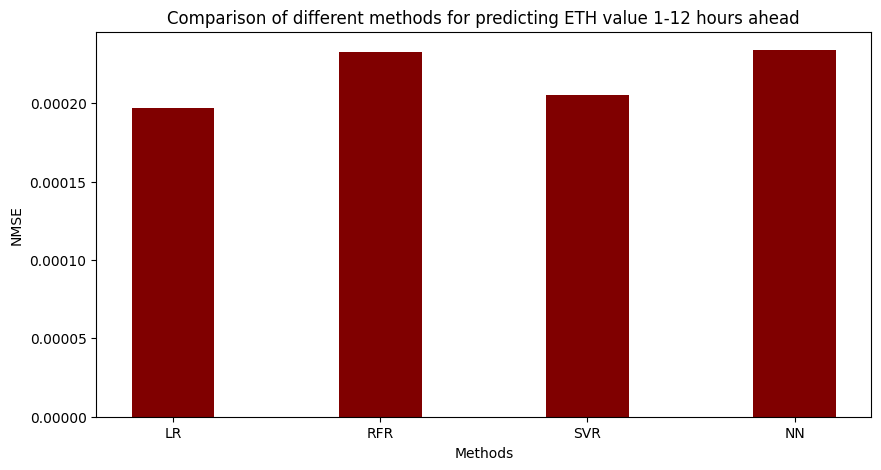

In [5]:
# Create models


# regression using a base estimator and RegressionChain
def fit_and_predict_reg(base_model,x_train,y_train,x_test,y_test):
  chain = RegressorChain(base_estimator=base_model).fit(x_train, y_train)  
  yhat_test = chain.predict(x_test)
  return calc_nmse(y_test,yhat_test)

# Neural network using Keras, 2 hidden layers with RELU activations, output layer with linear activations 
def fit_andpredict_fcnn(x_train,y_train,x_test,y_test):
  inputs = Input(shape=(x_train.shape[1],))
  x = Dense(128,activation='relu')(inputs)
  x = Dense(64,activation='relu')(x)
  outputs = Dense(12,activation='linear')(x)
  model = Model(inputs=inputs,outputs=outputs)
  # set compiling parameters
  model.compile( optimizer="adam", loss='mean_absolute_percentage_error',metrics=[])
  # Fit model
  model.fit(x_train,y_train,batch_size=100, epochs=500, validation_split=0.1, verbose=0)
  # predict
  yhat_test = model.predict(x_test)
  return calc_nmse(y_test,yhat_test)

# multi-output linear regression
from sklearn.linear_model import LinearRegression 
linreg = LinearRegression()
linreg_error = fit_and_predict_reg(linreg,x_train,y_train,x_test,y_test)

# multi-output random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
rfr = RandomForestRegressor(max_depth=10)
rfr_error = fit_and_predict_reg(rfr,x_train,y_train,x_test,y_test)

# multi-output support vector machines
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1000, epsilon=.1)
svr_error = fit_and_predict_reg(svr,x_train,y_train,x_test,y_test)

# Dense NN
dnn_error = fit_andpredict_fcnn(x_train,y_train,x_test,y_test)


# Plot results

info = {'LR':linreg_error, 'RFR':rfr_error, 'SVR':svr_error,'NN':dnn_error}
methods = list(info.keys())
values = list(info.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(methods, values, color ='maroon', width = 0.4)
 
plt.xlabel("Methods")
plt.ylabel("NMSE")
plt.title("Comparison of different methods for predicting ETH value 1-12 hours ahead")
plt.show()